<a href="https://colab.research.google.com/github/Untick/NetOptik/blob/main/Brutyan%20Ruben/2_1_2_%D0%9A%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%BE_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B_%D0%B2%D1%8B%D0%B2%D0%BE%D0%B4%D1%8B_(%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D1%81_VGG16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузка библиотек

In [ ]:
import os # Для работы с файлами

from tensorflow.keras.models import Sequential                                                                 # абстрактный класс базовой модели сети от кераса
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Flatten  # слои(нормализации, регуляризации и т.д)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import utils

from tensorflow.keras.preprocessing.image import ImageDataGenerator             # модуль ImageDataGenerator из библиотеки tensorflow

import matplotlib.pyplot as plt                                                 # для создания графиков и визуализаций в Python
import random                                                                   # для генерации случайных чисел
from PIL import Image                                                           # методы для отрисовки изображений, обработки и манипулирования изображениями

# Начальные данные:

## Начальные переменные

In [ ]:
# Параметры для ImageDataGenerator:
batch_size = 32
img_height = 675
img_width = 450
augment_dir = '/content/drive/MyDrive/НетОптик/Dataset/test_augment'               # папка с клонами (новые фото)
augment_dir_1p = '/content/drive/MyDrive/НетОптик/Dataset/test_augment/class_1p'   # папка с клонами (пластик)
augment_dir_2m = '/content/drive/MyDrive/НетОптик/Dataset/test_augment/class_2m'   # папка с клонами (метал)

## Генератор - Test_а

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator             # модуль ImageDataGenerator из библиотеки tensorflow

# настройки для генератора данных изображений (ImageDataGenerator) в задаче обработки изображений
datagen = ImageDataGenerator(
    rotation_range=12,                            # случайные повороты в диапазоне [-12, 12] градусов
    width_shift_range=5.0,                        # случайное горизонтальное смещение в диапазоне [-5.0, 5.0]
    height_shift_range=5.0 ,                      # случайное вертикальное смещение в диапазоне [-5.0, 5.0]
    zoom_range=0.2,                               # случайное масштабирование в диапазоне [0.8, 1.2]
    horizontal_flip=True,                         # Случайное отражение изображений по горизонтали
    # validation_split=0.2                          # доля отводимая на валидацию от общего количества фото для валидации
)

# Генератор данных для ТЕСТИРОВАНИЯ на основе аугментированных изображений из каталога augment_dir
test_a_generator = datagen.flow_from_directory(
    augment_dir,                                     # Путь к тестовой аугментированной выборке
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False                                # Перемешивание выборки
)

Found 108 images belonging to 2 classes.


## X_Test , Y_Test

X_Test , Y_Test тензоры (из аугментированных)

In [ ]:
import numpy as np

num = 0
for x,y in test_a_generator:
    if  num == 0:
       X_test = x
       Y_test = y
    else:
       X_test = np.concatenate([X_test,x])
       Y_test = np.concatenate([Y_test,y])
    num += 1
    if  num == 4:                     # "num" = количество образцов в аугментированном наборе данных = 108, деленному на размер пакета (batch_size = 32)
      break

print('Общее количество образцов, высота-ширина изображений, количество цветовых каналов:')
print('X_test:', X_test.shape)                                                          # Размер выборок
print('Общее количество образцов:')
print('Y_test:', Y_test.shape)

Общее количество образцов, высота-ширина изображений, количество цветовых каналов:
X_test: (108, 450, 675, 3)
Общее количество образцов:
Y_test: (108,)


## Визуализация тензора

In [ ]:
print(Y_test)
print()
print("Метка №54 картинки из первого класса (Y_test):", Y_test[53])  # 54 картинка из первого класса
print("Метка первой картинки из второго класса (Y_test):",Y_test[54]) # первая картинка из второго класса
print("Метка №108 картинки из второго класса (Y_test):",Y_test[107]) # 54 картинка из второго второго

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Метка №54 картинки из первого класса (Y_test): 0.0
Метка первой картинки из второго класса (Y_test): 1.0
Метка №108 картинки из второго класса (Y_test): 1.0


# МОДЕЛЬ с VGG-16

## *Загрузка модели*

Загрузка обученной модели с VGG-16

In [ ]:
from tensorflow.keras.models import load_model

print('Загружаем сеть')

# Загружаем модель из файла
model = load_model("/content/drive/MyDrive/НетОптик/Save_models/net_optic_VGG16.h5")

print('Загрузка сети из файла net_optic_VGG16.h5 завершена')

Загружаем сеть
Загрузка сети из файла net_optic_VGG16.h5 завершена


## Проверка модели вручную

1/1 [==============================] - 0s 82ms/step


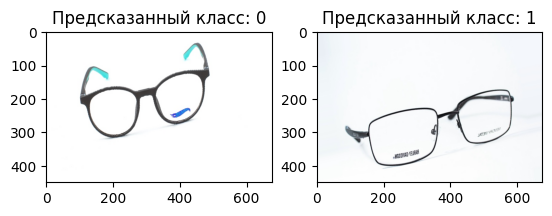

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# image_path_2m = '/content/drive/MyDrive/НетОптик/Dataset/augment_test/class_1p/1p_17.jpg'

# Путь к одному файлу из двух категорий (пластик или металл)
image_path_1p = augment_dir + '/' + 'class_1p' + '/' + '1p_53.jpg'
image_path_2m = augment_dir + '/' + 'class_2m' + '/' + '2m_0.jpg'

# Загрузка тестовой картинки из пластика
test_image_p = image.load_img(image_path_1p, target_size=(img_width, img_height))
test_image_p = image.img_to_array(test_image_p)
test_image_p = np.expand_dims(test_image_p, axis=0)

# Загрузка тестовой картинки из металла
test_image_m = image.load_img(image_path_2m, target_size=(img_width, img_height))
test_image_m = image.img_to_array(test_image_m)
test_image_m = np.expand_dims(test_image_m, axis=0)

# Предсказание класса тестовой картинки из папки пластик с использованием обученной модели
pred_p = model.predict(test_image_p)
pred_class_p = int(pred_p[0])

# Предсказание класса тестовой картинки из папки металл с использованием обученной модели
pred_m = model.predict(test_image_m)
pred_class_m = int(pred_m[0])

# Отображение тестовой картинки из папки пластик и предсказанного класса
plt.subplot(1, 2, 1)
plt.imshow(test_image_p[0].astype(np.uint8))
plt.title(f'Предсказанный класс: {pred_class_p}')

# Отображение тестовой картинки из папки металл и предсказанного класса
plt.subplot(1, 2, 2)
plt.imshow(test_image_m[0].astype(np.uint8))
plt.title(f'Предсказанный класс: {pred_class_m}')

plt.show()

# Выводы о качестве работы модели

Оценка качества работы модели нейронной сети может быть выполнена с помощью различных метрик. Некоторые из них:

1. Точность (Accuracy): определяет, насколько часто модель дает правильный ответ. Это отношение количества правильных предсказаний к общему числу предсказаний.

2. Полнота (Recall): измеряет, насколько хорошо модель находит положительные примеры из всего множества положительных примеров. Это отношение количества верно классифицированных положительных примеров к общему числу положительных примеров.

3. Точность предсказания (Precision): определяет, насколько точно модель классифицирует положительные примеры. Это отношение количества верно классифицированных положительных примеров к общему числу предсказанных положительных примеров.

4. F-мера (F1-score): это гармоническое среднее между полнотой и точностью предсказания. Она дает более сбалансированную оценку качества модели, учитывая и полноту, и точность.

### Точность (Accuracy)

Оценка модели на тестовых данных.  Генератор test_a_generator подает тестовые образцы в модель, с шагами, определенными как test_samples // batch_size.

In [ ]:
import os # Для работы с файлами

test_samples = len(os.listdir(augment_dir_1p)) + len(os.listdir(augment_dir_2m))
print(f'Всего тестовых изображений: {test_samples}\n')
scores = model.evaluate(test_a_generator, steps=test_samples // batch_size)
print("\nTest_accuracy (точность работы модели) на тестовых данных: %.2f%%" % (scores[1]*100))

Всего тестовых изображений: 108

3/3 [==============================] - 346s 113s/step - loss: 0.1481 - accuracy: 0.9792

Test_accuracy (точность работы модели) на тестовых данных: 97.92%


Вычисляем метрику accuracy

In [ ]:
# Вычисляем метрику accuracy
loss, accuracy = model.evaluate(X_test, Y_test)

# Выводим полученные результаты
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

4/4 [==============================] - 376s 89s/step - loss: 0.0784 - accuracy: 0.9722
Loss: 0.07838848233222961
Accuracy: 0.9722222089767456


### График confusion_matrix - на X_test и Y_test

4/4 [==============================] - 3s 781ms/step


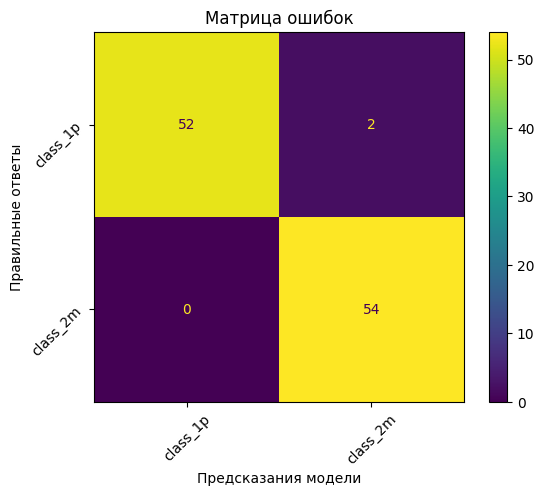

In [ ]:
# Импорт метода построения confusion_matrix
from sklearn.metrics import confusion_matrix
# Импорт метода визуализации confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Получение предсказанных значений модели для тестового набора данных
# y_pred = model.predict(test_a_generator)
y_pred = model.predict(X_test)

y_pred = np.round(y_pred).flatten()                    # округление до целых чисел и преобразование в одномерный массив

# Получение истинных значений тестового набора данных
# y_test = test_a_generator.classes
y_test = Y_test

# Построение confusion matrix
cm = confusion_matrix(y_test, y_pred)

TEST_CLASS_LIST = sorted(os.listdir(augment_dir))

# # Визуализация матрицы ошибок
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Пластик', 'Метал'])
display_label = np.arange(len(TEST_CLASS_LIST))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = display_label)
disp.plot()

plt.title('Матрица ошибок')
plt.xticks(display_label, TEST_CLASS_LIST, rotation=45)
plt.yticks(display_label, TEST_CLASS_LIST, rotation=45)
plt.xlabel('Предсказания модели')
plt.ylabel('Правильные ответы')
plt.show()

### График confusion_matrix - на генераторе

4/4 [==============================] - 8s 2s/step


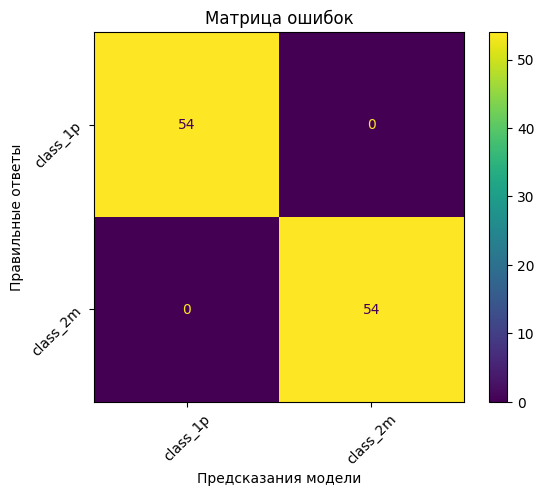

In [ ]:
from sklearn.metrics import confusion_matrix                                    # Импорт метода построения confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay                              # Импорт метода визуализации confusion_matrix

# Получение предсказанных значений модели для тестового набора данных
y_pred = model.predict(test_a_generator)
# y_pred = model.predict(X_test)

y_pred = np.round(y_pred).flatten()                                             # округление до целых чисел и преобразование в одномерный массив

# Получение истинных значений тестового набора данных
y_test = test_a_generator.classes
# y_test = Y_test

# Построение confusion matrix
cm = confusion_matrix(y_test, y_pred)

TEST_CLASS_LIST = sorted(os.listdir(augment_dir))

# # Визуализация матрицы ошибок
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Пластик', 'Метал'])
display_label = np.arange(len(TEST_CLASS_LIST))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = display_label)
disp.plot()

plt.title('Матрица ошибок')
plt.xticks(display_label, TEST_CLASS_LIST, rotation=45)
plt.yticks(display_label, TEST_CLASS_LIST, rotation=45)
plt.xlabel('Предсказания модели')
plt.ylabel('Правильные ответы')
plt.show()

## Расчет метрики precision

Метрика precision показывает: насколько хорошо модель способна отличать выбранный класс от всех остальных. Для этого количество правильных ответов для выбранного класса (51 для пластика) нужно разделить на количество примеров, когда модель предсказала выбранный класс пластик (51+0).

In [ ]:
import numpy as np

# Получение предсказанных значений модели для тестового набора данных
y_pred = model.predict(test_a_generator)
# y_pred = model.predict(X_test)

y_pred = np.round(y_pred).flatten()                    # округление до целых чисел и преобразование в одномерный массив

# Получение истинных значений тестового набора данных
y_test = test_a_generator.classes
# y_test = Y_test

# Построение confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Расчет метрики precision для класса пластик
precision_class_p = cm[0,0] / sum(cm[:,0])
print('Метрика precision для класса пластик', precision_class_p)

# Расчет метрики precision для класса металл
precision_class_m = cm[1,1] / sum(cm[:,1])
print('Метрика precision для класса металл',precision_class_m)

4/4 [==============================] - 8s 2s/step
Метрика precision для класса пластик 1.0
Метрика precision для класса металл 0.9473684210526315


Вывод: Модель отлично справляется с фильтрацией пластика от металла (100%), и чуть хуже в обратном случае, когда нужно отличить металл от пластика (95%)

## Метрика recall

Метрика recall показыает насколько хорошо модель в принципе способна находить выбранный класс. В случае этой метрики мы берем общеее количество правильных ответов выбранного класса пластик (52) и делим на общее количество примеров выбранного класса - пластик в проверочном наборе (52+2).

In [ ]:
# Расчет метрики recall для класса пластик
recall_class_p = cm[0,0] / sum(cm[0])
print('Метрика recall для класса пластик', recall_class_p)

# Расчет метрики recall для класса металл
recall_class_m = cm[1,1] / sum(cm[1])
print('Метрика recall для класса металл', recall_class_m)

Метрика recall для класса пластик 0.9444444444444444
Метрика recall для класса металл 1.0


После того, как посчитали метрики для каждого класса, можно объединить их для получения результирующих метрик.

Есть различные подходы к подобному объединению. В sklearn'е реализовано два варианта.

1. С помощью простого среднего арифметического
2. С помощью взвешенного среднего арифметического

In [ ]:
# Расчет метрик через среднее арифметическое (_1)
precision_1 = (precision_class_p + precision_class_m) / 2
recall_1 = (recall_class_p + recall_class_m) / 2
print(f'precision (ср. ариф.) {precision_1}')
print(f'recall (ср. ариф.)    {recall_1}')

# Расчет метрик через среднее арифметическое взвешенное (_2)
precision_2 = (precision_class_p * sum(cm[0]) + precision_class_m * sum(cm[1])) / len(y_test)
recall_2 = (recall_class_p * sum(cm[0]) + recall_class_m * sum(cm[1]))  / len(y_test)
print(f'precision (ср. ариф. взв.) {precision_2}')
print(f'recall (ср. ариф. взв.)    {recall_2}')

precision (ср. ариф.) 0.9736842105263157
recall (ср. ариф.)    0.9722222222222222
precision (ср. ариф. взв.) 0.9736842105263158
recall (ср. ариф. взв.)    0.9722222222222222


## Метрика f1-score

Метрика f1-score является средним гармоническим между presicion и recall и расчитывается по формуле:


$f1 = 2 * \frac{recall *precision}{recall + precision}$

По аналогии метрика f1-score расчитывается для каждого класса отдельно, а затем через среднее арифметическое (простое или взвешанное) получается финальный результат

In [ ]:
# Расчет f1_score для класса пластик
f1_class_p = 2 * (precision_class_p * recall_class_p) / (precision_class_p + recall_class_p)

# Расчет f1_score для класса металл
f1_class_m = 2 * (precision_class_m * recall_class_m) / (precision_class_m + recall_class_m)

print(f1_class_p)
print(f1_class_m)

0.9714285714285714
0.972972972972973


In [ ]:
# Расчет f1-score через среднее арифметическое
f1_score_1 = (f1_class_p + f1_class_m) / 2

# Расчет f1-score через среднее арифметическое взвешенное
f1_score_2 = (f1_class_p *  sum(cm[0]) + f1_class_m  * sum(cm[1])) / len(y_test)

print(f1_score_1)
print(f1_score_2)

0.9722007722007722
0.9722007722007723


## *Метод `precision_recall_fscore_support`*

Расчет метрик можно выполнить с помощью готового метода библиотеки sclearn

In [ ]:
# Импорт метода расчета метрик
from sklearn.metrics import precision_recall_fscore_support

import numpy as np

# Получение предсказанных значений модели для тестового набора данных
y_pred = model.predict(test_a_generator)
# y_pred = model.predict(X_test)

y_pred = np.round(y_pred).flatten()                    # округление до целых чисел и преобразование в одномерный массив

# Получение истинных значений тестового набора данных
y_test = test_a_generator.classes
# y_test = Y_test

# Параметр average задает способ получения финального значения метрик:
# 'macro'    - расчет через простое среднее арифметическое
# 'weighted' - расчет с помощью взвешанного среднего арифметического
metrics = precision_recall_fscore_support(y_test, y_pred, average='macro')

print(metrics)
print()
print(f'precision: {metrics[0]}')
print(f'recall:    {metrics[1]}')
print(f'f1_score:  {metrics[2]}')

4/4 [==============================] - 8s 2s/step
(0.9821428571428572, 0.9814814814814814, 0.9814751286449399, None)
precision: 0.9821428571428572
recall:    0.9814814814814814
f1_score:  0.9814751286449399
